In [ ]:
# Install pydrive2
!pip install -U -q PyDrive2

# Authenticate and import libraries
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate user
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file with title 'recapture_dataset.zip'
file_list = drive.ListFile({'q': "title='recapture_dataset.zip'"}).GetList()
if file_list:
    file_id = file_list[0]['id']
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile('recapture_dataset.zip')
    print("Download complete.")
else:
    print("File not found.")

# Unzip the file
!unzip -o 'recapture_dataset.zip'

Download complete.
Archive:  recapture_dataset.zip
   creating: recapture_dataset/
  inflating: recapture_dataset/.DS_Store  
  inflating: __MACOSX/recapture_dataset/._.DS_Store  
   creating: recapture_dataset/original/
  inflating: __MACOSX/recapture_dataset/._original  
   creating: recapture_dataset/recapture /
  inflating: __MACOSX/recapture_dataset/._recapture   
  inflating: recapture_dataset/original/andorid_soj2.jpeg  
  inflating: __MACOSX/recapture_dataset/original/._andorid_soj2.jpeg  
  inflating: recapture_dataset/original/IMG20230214150537.jpg  
  inflating: __MACOSX/recapture_dataset/original/._IMG20230214150537.jpg  
  inflating: recapture_dataset/original/android4.jpg  
  inflating: __MACOSX/recapture_dataset/original/._android4.jpg  
  inflating: recapture_dataset/original/IMG_20241125_185443.jpg  
  inflating: __MACOSX/recapture_dataset/original/._IMG_20241125_185443.jpg  
  inflating: recapture_dataset/original/IMG20230316172552.jpg  
  inflating: __MACOSX/recaptur

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.19.0


In [ ]:
# dataset = '/content/recapture_dataset'

# BATCH_SIZE = 32
# IMG_SIZE = (224, 224)
# train_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE,
#                                                                  validation_split=.20,
#                                                                  subset='training',
#                                                                  seed=66)
# validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE,
#                                                                  validation_split=.20,
#                                                                  subset='validation',
#                                                                  seed=66)

In [ ]:
import cv2
import os

# --- Manual paths ---
original_dir = '/content/recapture_dataset/original'
recap_dir = '/content/recapture_dataset/recapture '

# --- Parent folder to save Canny edge images ---
parent_save_dir = '/content/canny_dataset'
save_dir_ori = os.path.join(parent_save_dir, 'canny_original')
save_dir_recap = os.path.join(parent_save_dir, 'canny_recapture')

# Create directories if they don't exist
os.makedirs(save_dir_ori, exist_ok=True)
os.makedirs(save_dir_recap, exist_ok=True)

# --- Parameters for Canny ---
canny_low_threshold = 100
canny_high_threshold = 200

# --- Function to process images using Canny edge detection ---
def process_image_canny(path):
    image = cv2.imread(path)
    if image is None:
        print(f"Warning: Could not load image at {path}")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, canny_low_threshold, canny_high_threshold)
    return edges

# --- Supported file types ---
supported_extensions = ('.jpg', '.jpeg', '.png')

# --- Process and save all original images ---
for f in os.listdir(original_dir):
    if f.lower().endswith(supported_extensions):
        path = os.path.join(original_dir, f)
        edges_img = process_image_canny(path)
        if edges_img is not None:
            save_path = os.path.join(save_dir_ori, f)
            cv2.imwrite(save_path, edges_img)

# --- Process and save all recapture images ---
for f in os.listdir(recap_dir):
    if f.lower().endswith(supported_extensions):
        path = os.path.join(recap_dir, f)
        edges_img = process_image_canny(path)
        if edges_img is not None:
            save_path = os.path.join(save_dir_recap, f)
            cv2.imwrite(save_path, edges_img)

print("All images processed and saved with Canny edges!")


All images processed and saved with Canny edges!


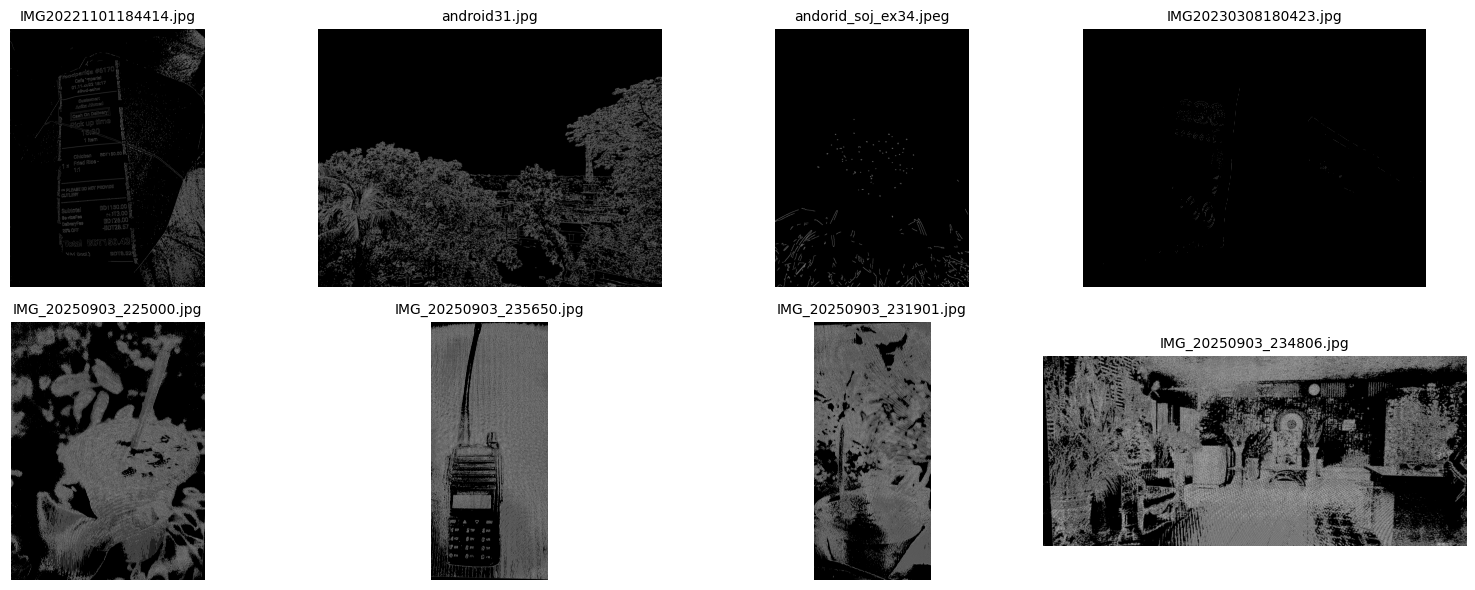

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Paths for thresholded images ---
save_dir_ori = '/content/canny_dataset/canny_original'
save_dir_recap = '/content/canny_dataset/canny_recapture'

# --- Function to load and prepare images for plotting ---
def load_images_for_plot(folder, num_images=4):
    supported_extensions = ('.jpg', '.jpeg', '.png')
    files = [f for f in os.listdir(folder) if f.lower().endswith(supported_extensions)]
    files = files[:num_images]  # pick first 4 images
    imgs = []
    for f in files:
        img = cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Convert to RGB for matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            imgs.append((f, img_rgb))
    return imgs

# --- Load 4 images from each folder ---
ori_imgs = load_images_for_plot(save_dir_ori, num_images=4)
recap_imgs = load_images_for_plot(save_dir_recap, num_images=4)

# --- Plot images ---
plt.figure(figsize=(16, 6))

# Original thresholded images
for i, (fname, img) in enumerate(ori_imgs):
    plt.subplot(2, 4, i+1)
    plt.imshow(img.astype(np.float32)/255.0)
    plt.title(fname, fontsize=10)
    plt.axis('off')

# Recapture thresholded images
for i, (fname, img) in enumerate(recap_imgs):
    plt.subplot(2, 4, 4 + i + 1)
    plt.imshow(img.astype(np.float32)/255.0)
    plt.title(fname, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


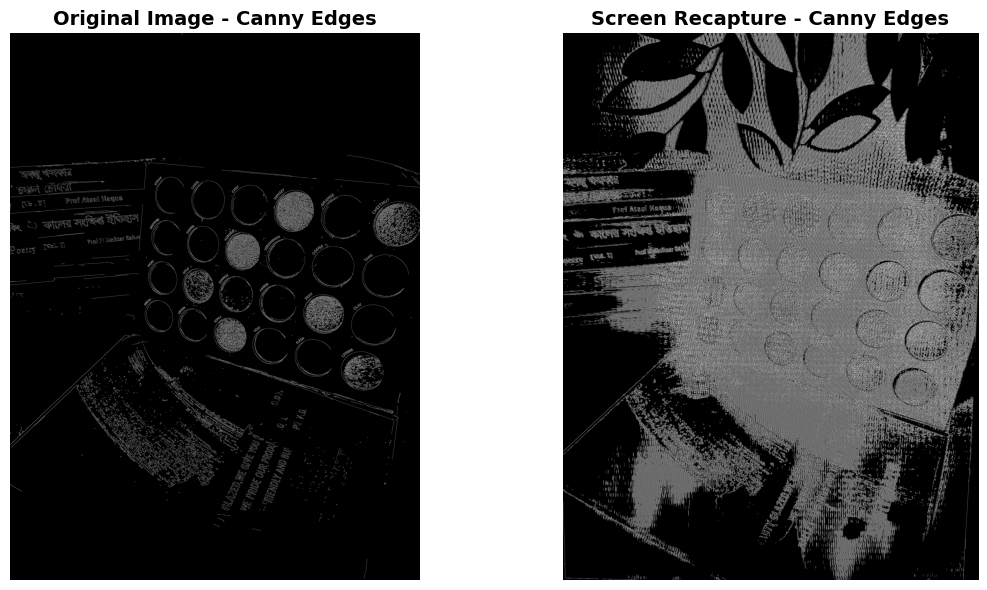

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# --- Paths ---
save_dir_ori = '/content/canny_dataset/canny_original'
save_dir_recap = '/content/canny_dataset/canny_recapture'

# --- Image filename to display ---
img_name = '1.jpg'

# --- Load images ---
img_ori_path = os.path.join(save_dir_ori, img_name)
img_recap_path = os.path.join(save_dir_recap, img_name)

img_ori = cv2.imread(img_ori_path, cv2.IMREAD_GRAYSCALE)
img_recap = cv2.imread(img_recap_path, cv2.IMREAD_GRAYSCALE)

# Convert to RGB for matplotlib
img_ori_rgb = cv2.cvtColor(img_ori, cv2.COLOR_GRAY2RGB)
img_recap_rgb = cv2.cvtColor(img_recap, cv2.COLOR_GRAY2RGB)

# --- Plot side by side ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_ori_rgb.astype(float)/255.0)
plt.title('Original Image - Canny Edges', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_recap_rgb.astype(float)/255.0)
plt.title('Screen Recapture - Canny Edges', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
#train_dir = '/content/BDNRB/train'
#validation_dir = '/content/BDNRB/validation'
#test_dir = '/content/BDNRB/test'

dataset = '/content/canny_dataset'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='training',
                                                                 seed=66)
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='validation',
                                                                 seed=66)
#test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
#                                                                 shuffle=True,
 #                                                                batch_size=BATCH_SIZE,
 #                                                                image_size=IMG_SIZE)
class_names = validation_dataset.class_names

Found 1025 files belonging to 2 classes.
Using 820 files for training.
Found 1025 files belonging to 2 classes.
Using 205 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

In [ ]:
base_model = keras.applications.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
nb_classes = 2
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)

outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)
#modelF = model

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,852,898 (87.18 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Define callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[reduce_lr, early_stop])

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.7378 - loss: 0.7012 - val_accuracy: 0.9306 - val_loss: 0.1391 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.9693 - loss: 0.0960 - val_accuracy: 0.9249 - val_loss: 0.1953 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.9595 - loss: 0.1067 - val_accuracy: 0.9711 - val_loss: 0.0970 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.9756 - loss: 0.0743 - val_accuracy: 0.9653 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.9604 - loss: 0.1015 - val_accuracy: 0.9133 - val_loss: 0.2001 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.9655 - loss: 0.0937 - val_accuracy: 0.9769 - val_loss: 0.0635 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.9801 - l

In [ ]:
scores = model.evaluate(validation_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.9845 - loss: 0.0533


In [ ]:
base_model.trainable = True
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,953,128 (95.19 MB)

 Trainable params: 22,818,466 (87.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 2,100,230 (8.01 MB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[reduce_lr, early_stop])

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 591ms/step - accuracy: 0.8580 - loss: 0.3415 - val_accuracy: 0.9769 - val_loss: 0.0516 - learning_rate: 1.0000e-05
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.9509 - loss: 0.1550 - val_accuracy: 0.9884 - val_loss: 0.0325 - learning_rate: 1.0000e-05
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 401ms/step - accuracy: 0.9646 - loss: 0.1052 - val_accuracy: 0.9884 - val_loss: 0.0329 - learning_rate: 1.0000e-05
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.9647 - loss: 0.1141 - val_accuracy: 0.9942 - val_loss: 0.0285 - learning_rate: 1.0000e-05
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.9733 - loss: 0.0913 - val_accuracy: 0.9884 - val_loss: 0.0363 - learning_rate: 1.0000e-05
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - accuracy: 0.9809 - loss: 0.0586 - val_accuracy: 0.9884 - val_loss: 0.0330 - learning_rate: 1.0000e-05
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step

In [ ]:
scores = model.evaluate(validation_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.9882 - loss: 0.0351


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


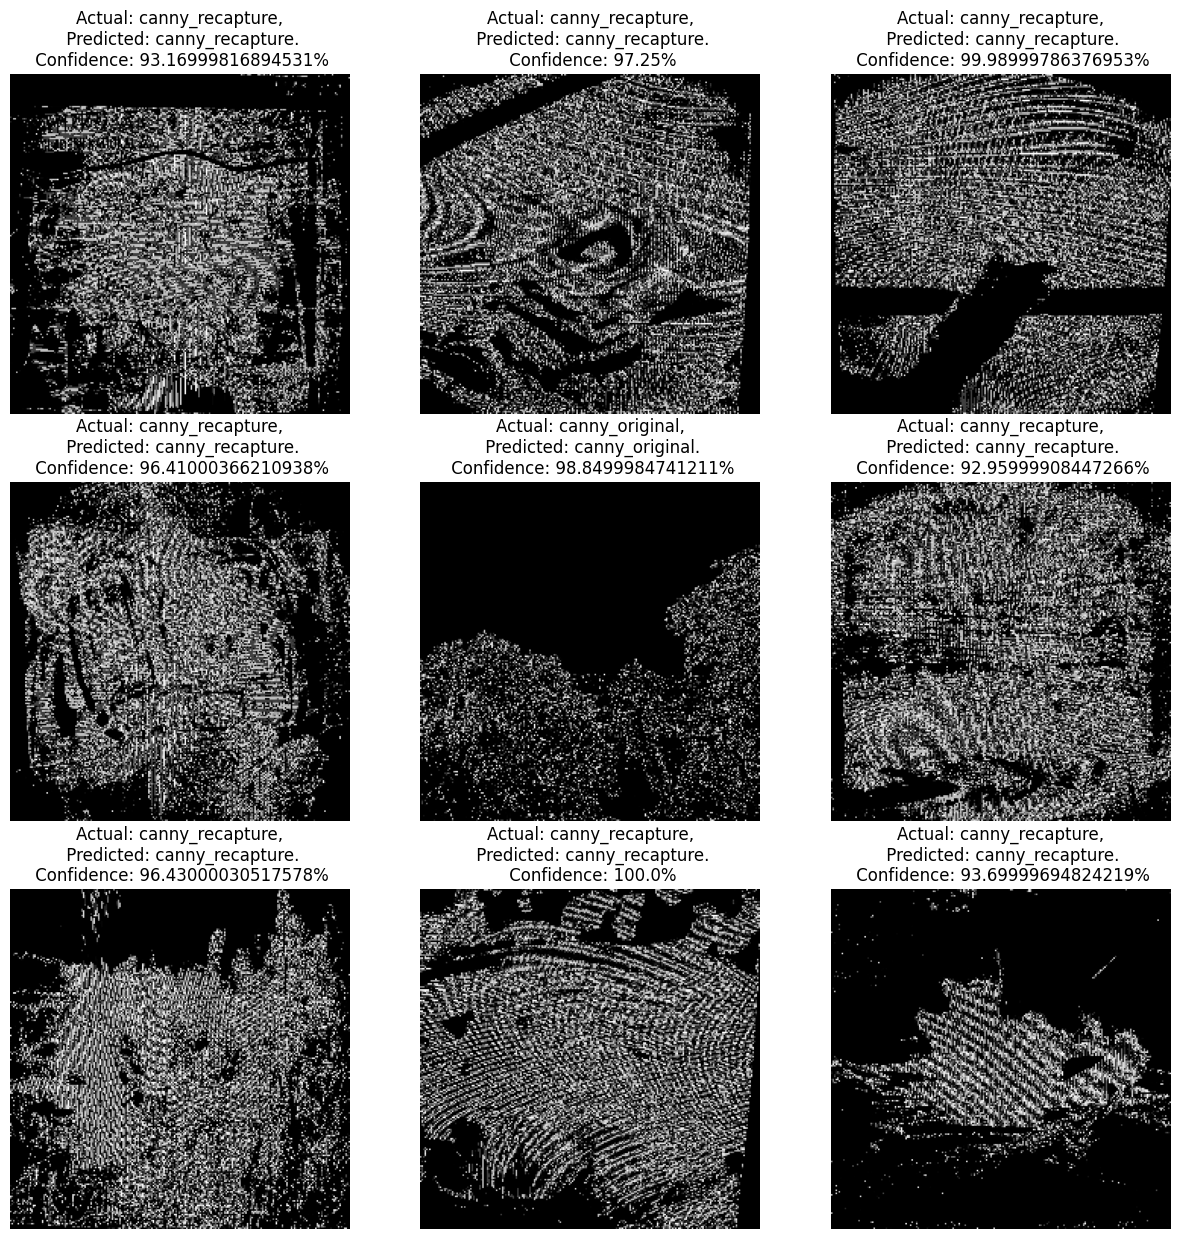

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━

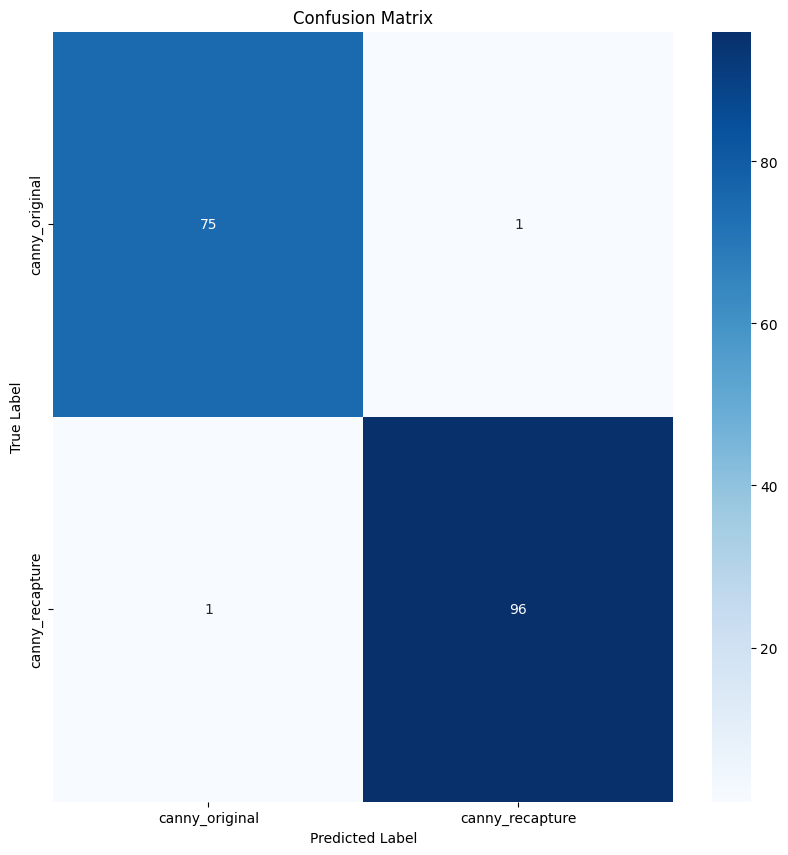

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in validation_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# ✅ Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# F1 Score
f1 = f1_score(true_labels, predicted_labels, average="weighted")

# Precision
precision = precision_score(true_labels, predicted_labels, average="weighted")

# Recall
recall = recall_score(true_labels, predicted_labels, average="weighted")

# ROC-AUC
# For ROC-AUC we need probabilities instead of predicted class
y_probs = []  # store probabilities
for images, _ in validation_dataset:
    probs = model.predict(images)
    y_probs.extend(probs)

y_probs = np.array(y_probs)

if nb_classes == 2:  # Binary classification
    roc_auc = roc_auc_score(true_labels, y_probs[:, 1])
else:  # Multiclass classification
    roc_auc = roc_auc_score(true_labels, y_probs, multi_class="ovr", average="weighted")

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━